# Substitution

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [836]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

## Raw Data

### Uricchio et al. Data

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Load B and R Maps

In [5]:
ratchet_pkl = '../data/bmaps/bgspy/bmap_hg37_ratchet_10000step_10000N_cds_utrs_phastcons.pkl'
ratchet_m = BGSModel.load(ratchet_pkl)

In [6]:
ratchet_m

In [837]:
f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
f

/home/vsb/projects/bprime/bgspy/likelihood.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm
/tmp/ipykernel_45271/3719401649.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


(MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-likelihood: 916117190701.985
 π0 = 0.001804663644383997
 R² = 62.421
 W = 
           cds    phastcons    utr
 ------  -----  -----------  -----
 1e-07   0            0      0.001
 1e-06   0.001        0      0.001
 1e-05   0.001        0      0.004
 0.0001  0.002        0.001  0.083
 0.001   0.007        0.162  0.016
 0.01    0.008        0.485  0.658
 0.1     0.981        0.35   0.236
 μ = 
         cds    phastcons          utr
 -----------  -----------  -----------
 2.14119e-08  2.77184e-08  8.07999e-09,
 MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-li

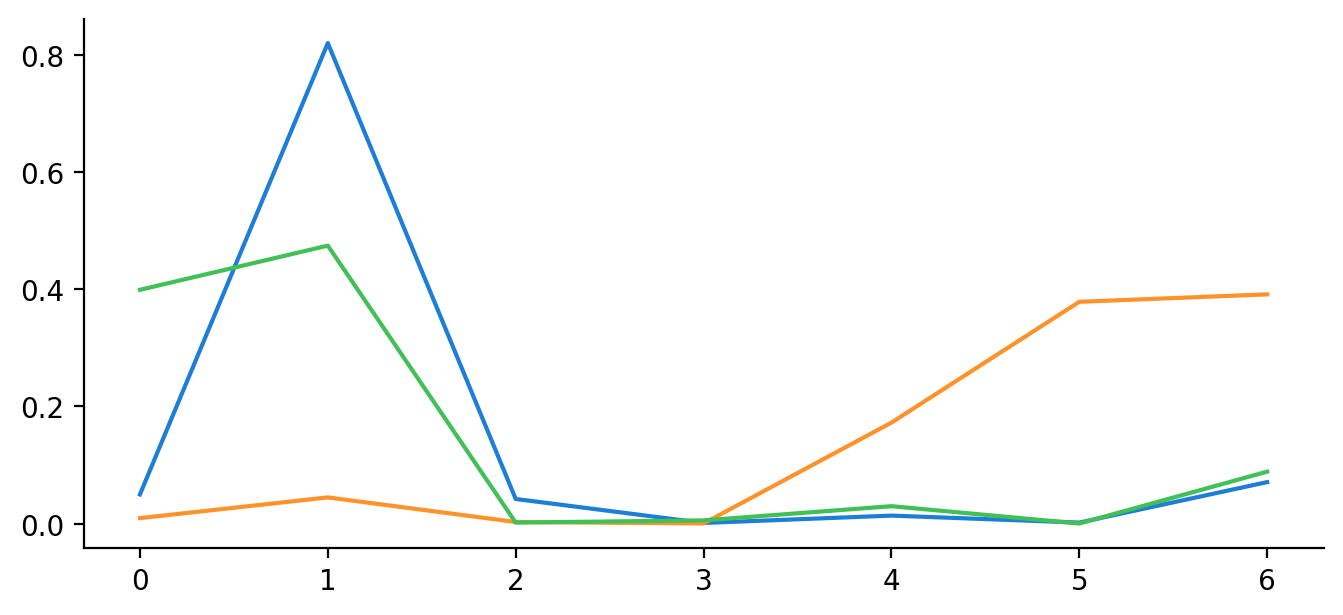

In [842]:
plt.plot(f[1].mle_W_norm[:, 0])
plt.plot(f[1].mle_W_norm[:, 1])
plt.plot(f[1].mle_W_norm[:, 2])

In [853]:
ff = pickle.load(open('/home/vsb/projects/bprime/fits/oldfits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
                 
ff[1]                

/tmp/ipykernel_45271/2610925974.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/home/vsb/projects/bprime/fits/oldfits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  ff = pickle.load(open('/home/vsb/projects/bprime/fits/oldfits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


MLE (interpolated w): 6 x 6 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 914310683229.56
π0 = 0.0018134731637516881
R² = 67.2564
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-06   0.603        0.102  0.545
1e-05   0.185        0.001  0.016
0.0001  0.016        0      0.026
0.001   0.009        0.173  0.109
0.01    0.081        0.393  0.014
0.1     0.106        0.331  0.29
μ = 
        cds    phastcons          utr
-----------  -----------  -----------
1.32304e-09  3.31199e-08  3.24765e-08

In [852]:
np.round(f[1].mle_W_norm[:, 0], 2), np.round(f[1].mle_W_norm[:, 1], 2)

(array([0.05, 0.82, 0.04, 0.  , 0.01, 0.  , 0.07]),
 array([0.01, 0.04, 0.  , 0.  , 0.17, 0.38, 0.39]))

## PhyloFit Branch Length Estimates

In [7]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)

In [8]:
p.head()

,chrom,start,end,branch_length,bl_nbases
0,chr1,1059994,1095749,0.010402,72265
1,chr1,1283738,1308299,0.006782,52319
2,chr1,1564773,1623511,0.010483,178850
3,chr1,1626991,1655940,0.006026,63570
4,chr1,1752959,1789083,0.008125,86103


[]

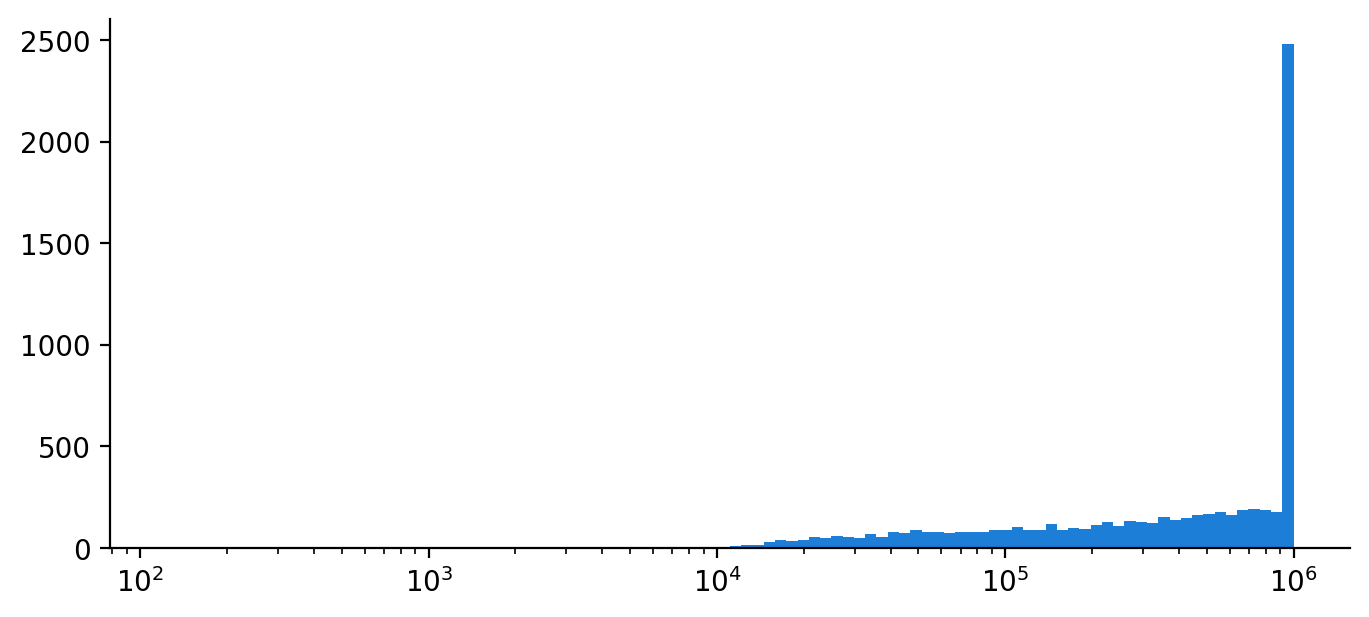

In [9]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [10]:
p['bl_nbases'].max()

1000000

## Analysis of Predicted Ratchet Rates for CDS/UTRS/PhastCons Model

In [818]:
# There are two ways to process this. 

dpf2r = pd.read_csv('../data/phylo/phylofit_to_ratchet.bed', sep='\t',
                na_values='.',
                names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases', 'branch_length'))

dr2pf = pd.read_csv('../data/phylo/ratchet_to_phylofit.bed', sep='\t',
                na_values='.',
                names=('chrom', 'start', 'end', 'branch_length', 'bl_nbases', 'r', 'r_nbases'))
dr2pf['width'] = dr2pf['end'] - dr2pf['start']
dpf2r.head(), dr2pf.head()                

(      chrom  start        end             R             r  r_nbases  \
 chr1  12007  12020  phastcons  8.606633e-08  6.620487e-09        13   
 chr1  12021  12035  phastcons  9.268696e-08  6.620497e-09        14   
 chr1  12039  12050  phastcons  7.282512e-08  6.620465e-09        11   
 chr1  12065  12085  phastcons  1.324112e-07  6.620561e-09        20   
 chr1  12176  12194  phastcons  1.191697e-07  6.620540e-09        18   
 
       branch_length  
 chr1            NaN  
 chr1            NaN  
 chr1            NaN  
 chr1            NaN  
 chr1            NaN  ,
   chrom    start      end  branch_length  bl_nbases             r  r_nbases  \
 0  chr1  1059994  1095749       0.010402      72265  1.749256e-08    6851.0   
 1  chr1  1283738  1308299       0.006782      52319  4.189097e-08    6842.0   
 2  chr1  1564773  1623511       0.010483     178850  3.405017e-08    4785.0   
 3  chr1  1626991  1655940       0.006026      63570  4.291974e-08    7670.0   
 4  chr1  1752959  1789083 

In [829]:
cols = ('chrom', 'start', 'end', 'R', 'r', 'r_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')

In [819]:
#a = binned_summaries(dpf2r['r'], dpf2r['branch_length'], nbins=50)
b = binned_summaries(dr2pf['r'], dr2pf['branch_length'], nbins=50)

<ErrorbarContainer object of 3 artists>

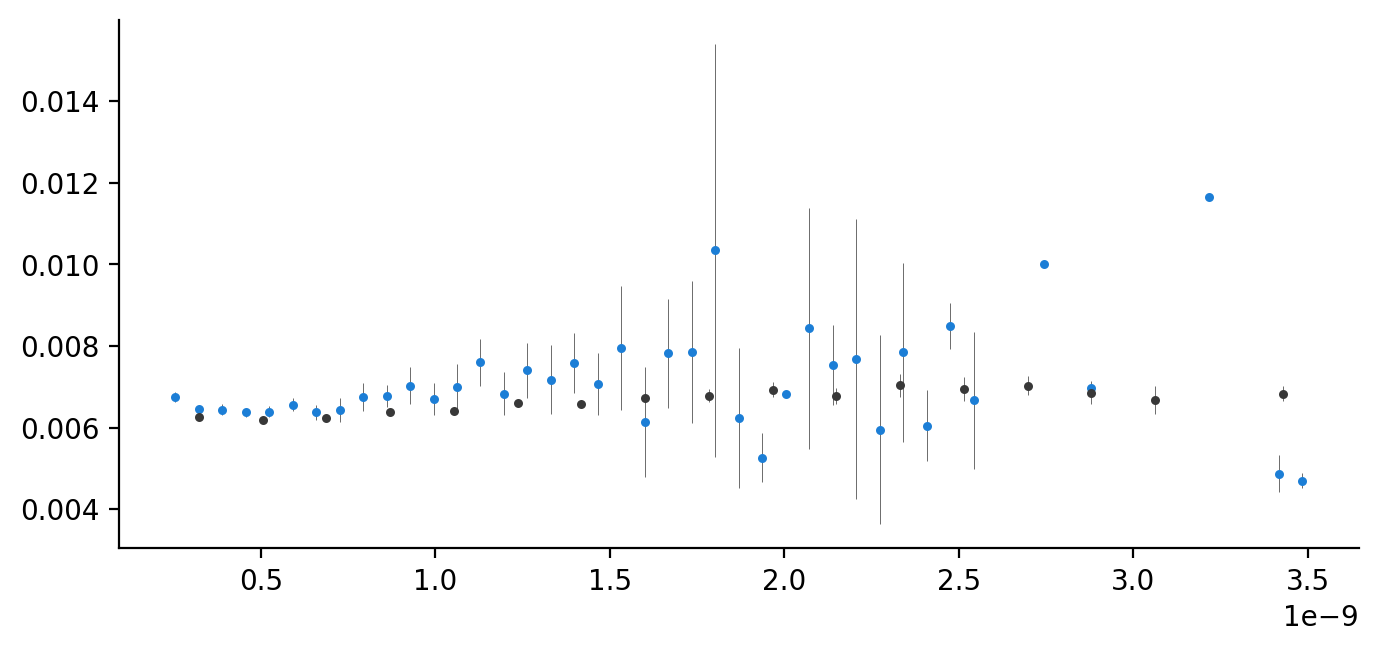

In [827]:
plt.scatter(b['midpoint']/gen, b['mean'], s=5, alpha=1, zorder=10)
plt.errorbar(b['midpoint']/gen, b['mean'], 2*b['sd']/np.sqrt(b['n']), fmt='none', c=error_col, elinewidth=0.3)

plt.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
plt.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

In [11]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    "r",
    "r_nbases",
    "branch_length",
    "bl_nbases",
]

d = pd.read_csv('../data/phylo/urrichio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']

In [12]:
d.head()

,chrom,start,end,gene_id,n_nonsyn,n_syn,fixed_nonsyn,fixed_syn,dnDs,total_fixed,...,gc3,syn_prop,nonsyn_prop,total_prop,dNdS,r,r_nbases,branch_length,bl_nbases,width
0,chr1,923923,944575,ENSG00000187634,28,21,8,4,2.000000,12,...,0.832938,0.001580,0.003160,0.004739,2.000000,2.502833e-08,4658,NaN,NaN,20652
1,chr1,944203,959309,ENSG00000188976,31,32,4,8,0.500000,12,...,0.794393,0.003560,0.001780,0.005340,0.500000,4.107783e-08,2950,NaN,NaN,15106
2,chr1,960584,965719,ENSG00000187961,11,28,0,8,0.000000,8,...,0.838006,0.004154,0.000000,0.004154,0.000000,4.222435e-08,2776,NaN,NaN,5135
3,chr1,966482,975865,ENSG00000187583,47,19,0,3,0.000000,3,...,0.801964,0.001637,0.000000,0.001637,0.000000,3.766140e-08,3800,NaN,NaN,9383
4,chr1,975198,982117,ENSG00000187642,31,22,11,3,3.666667,14,...,0.681013,0.001266,0.004641,0.005907,3.666667,4.105993e-08,4203,NaN,NaN,6919


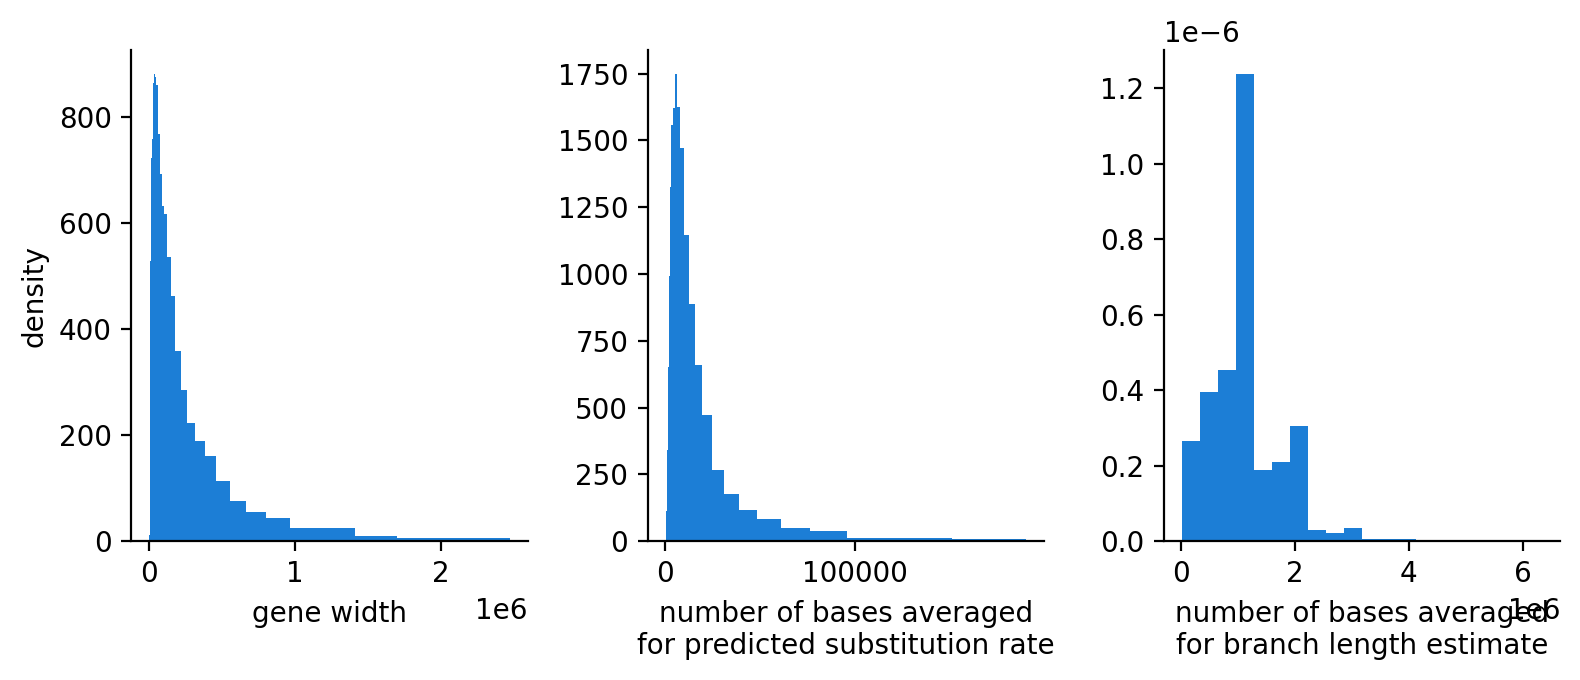

In [13]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

In [14]:
d['bl_nbases'].max()

6336248.0

Text(0.5, 0, 'predicted substitution rate')

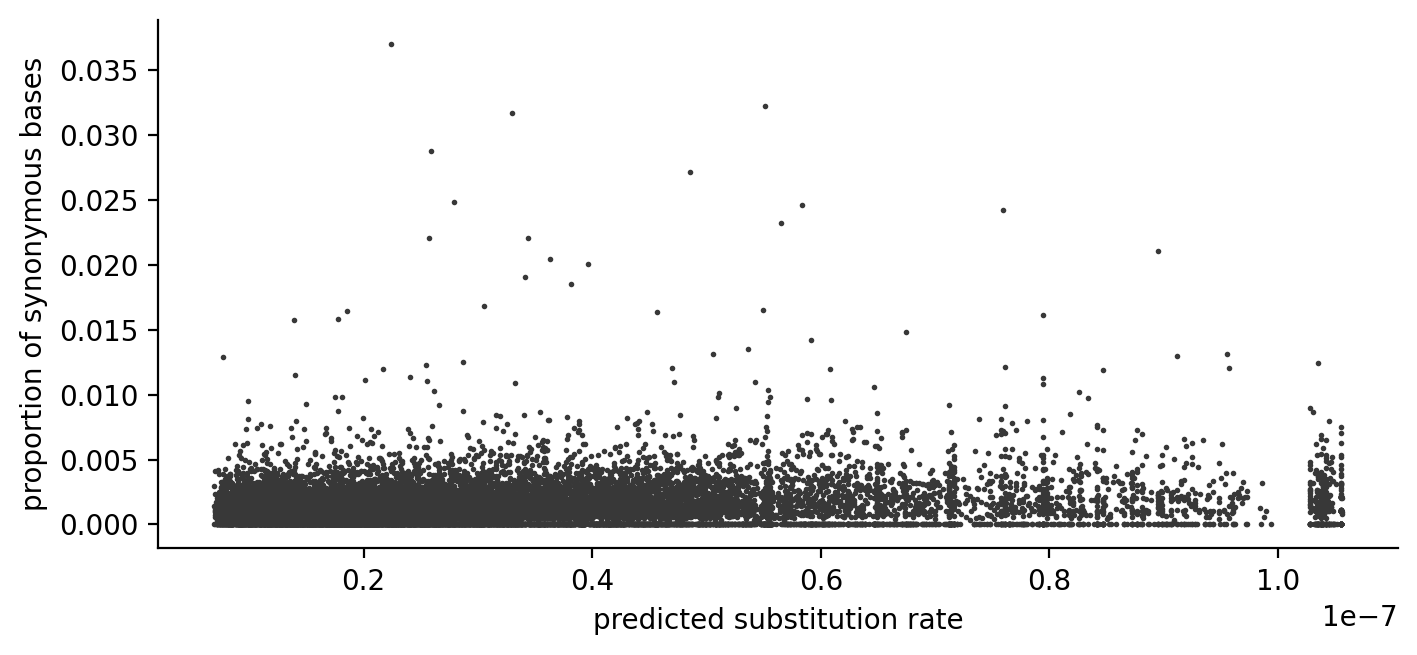

In [565]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

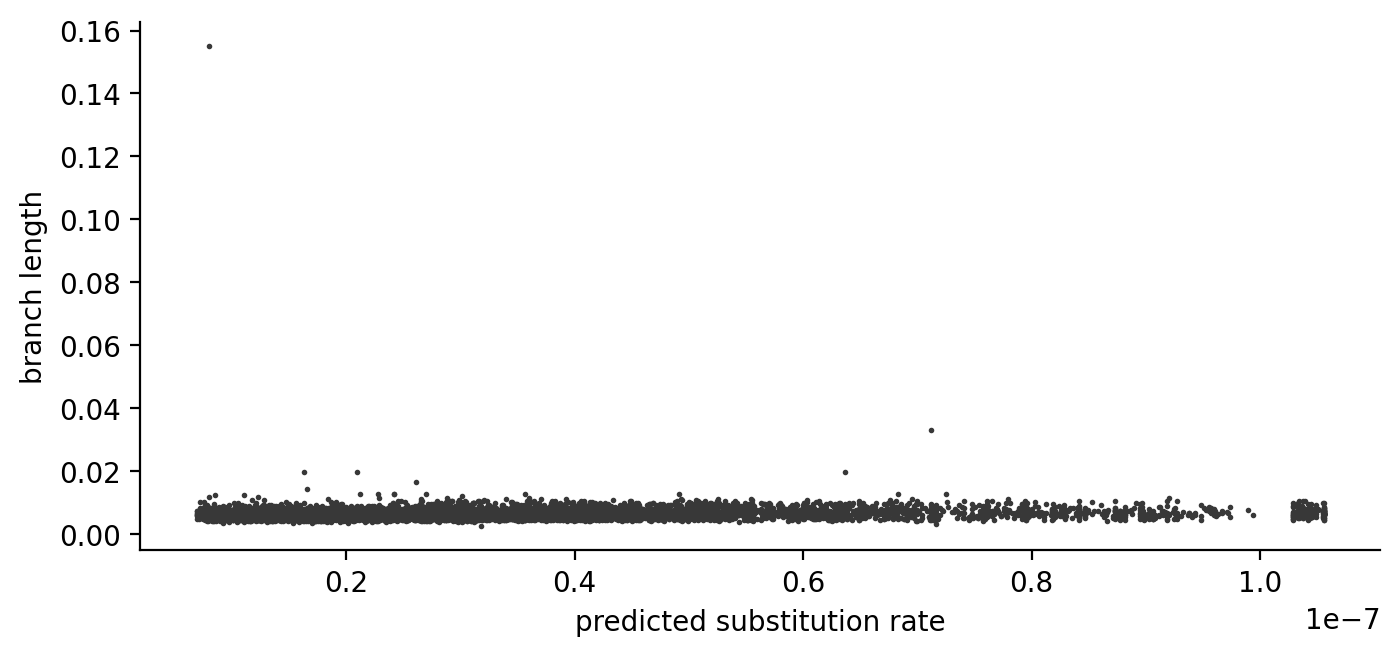

In [568]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

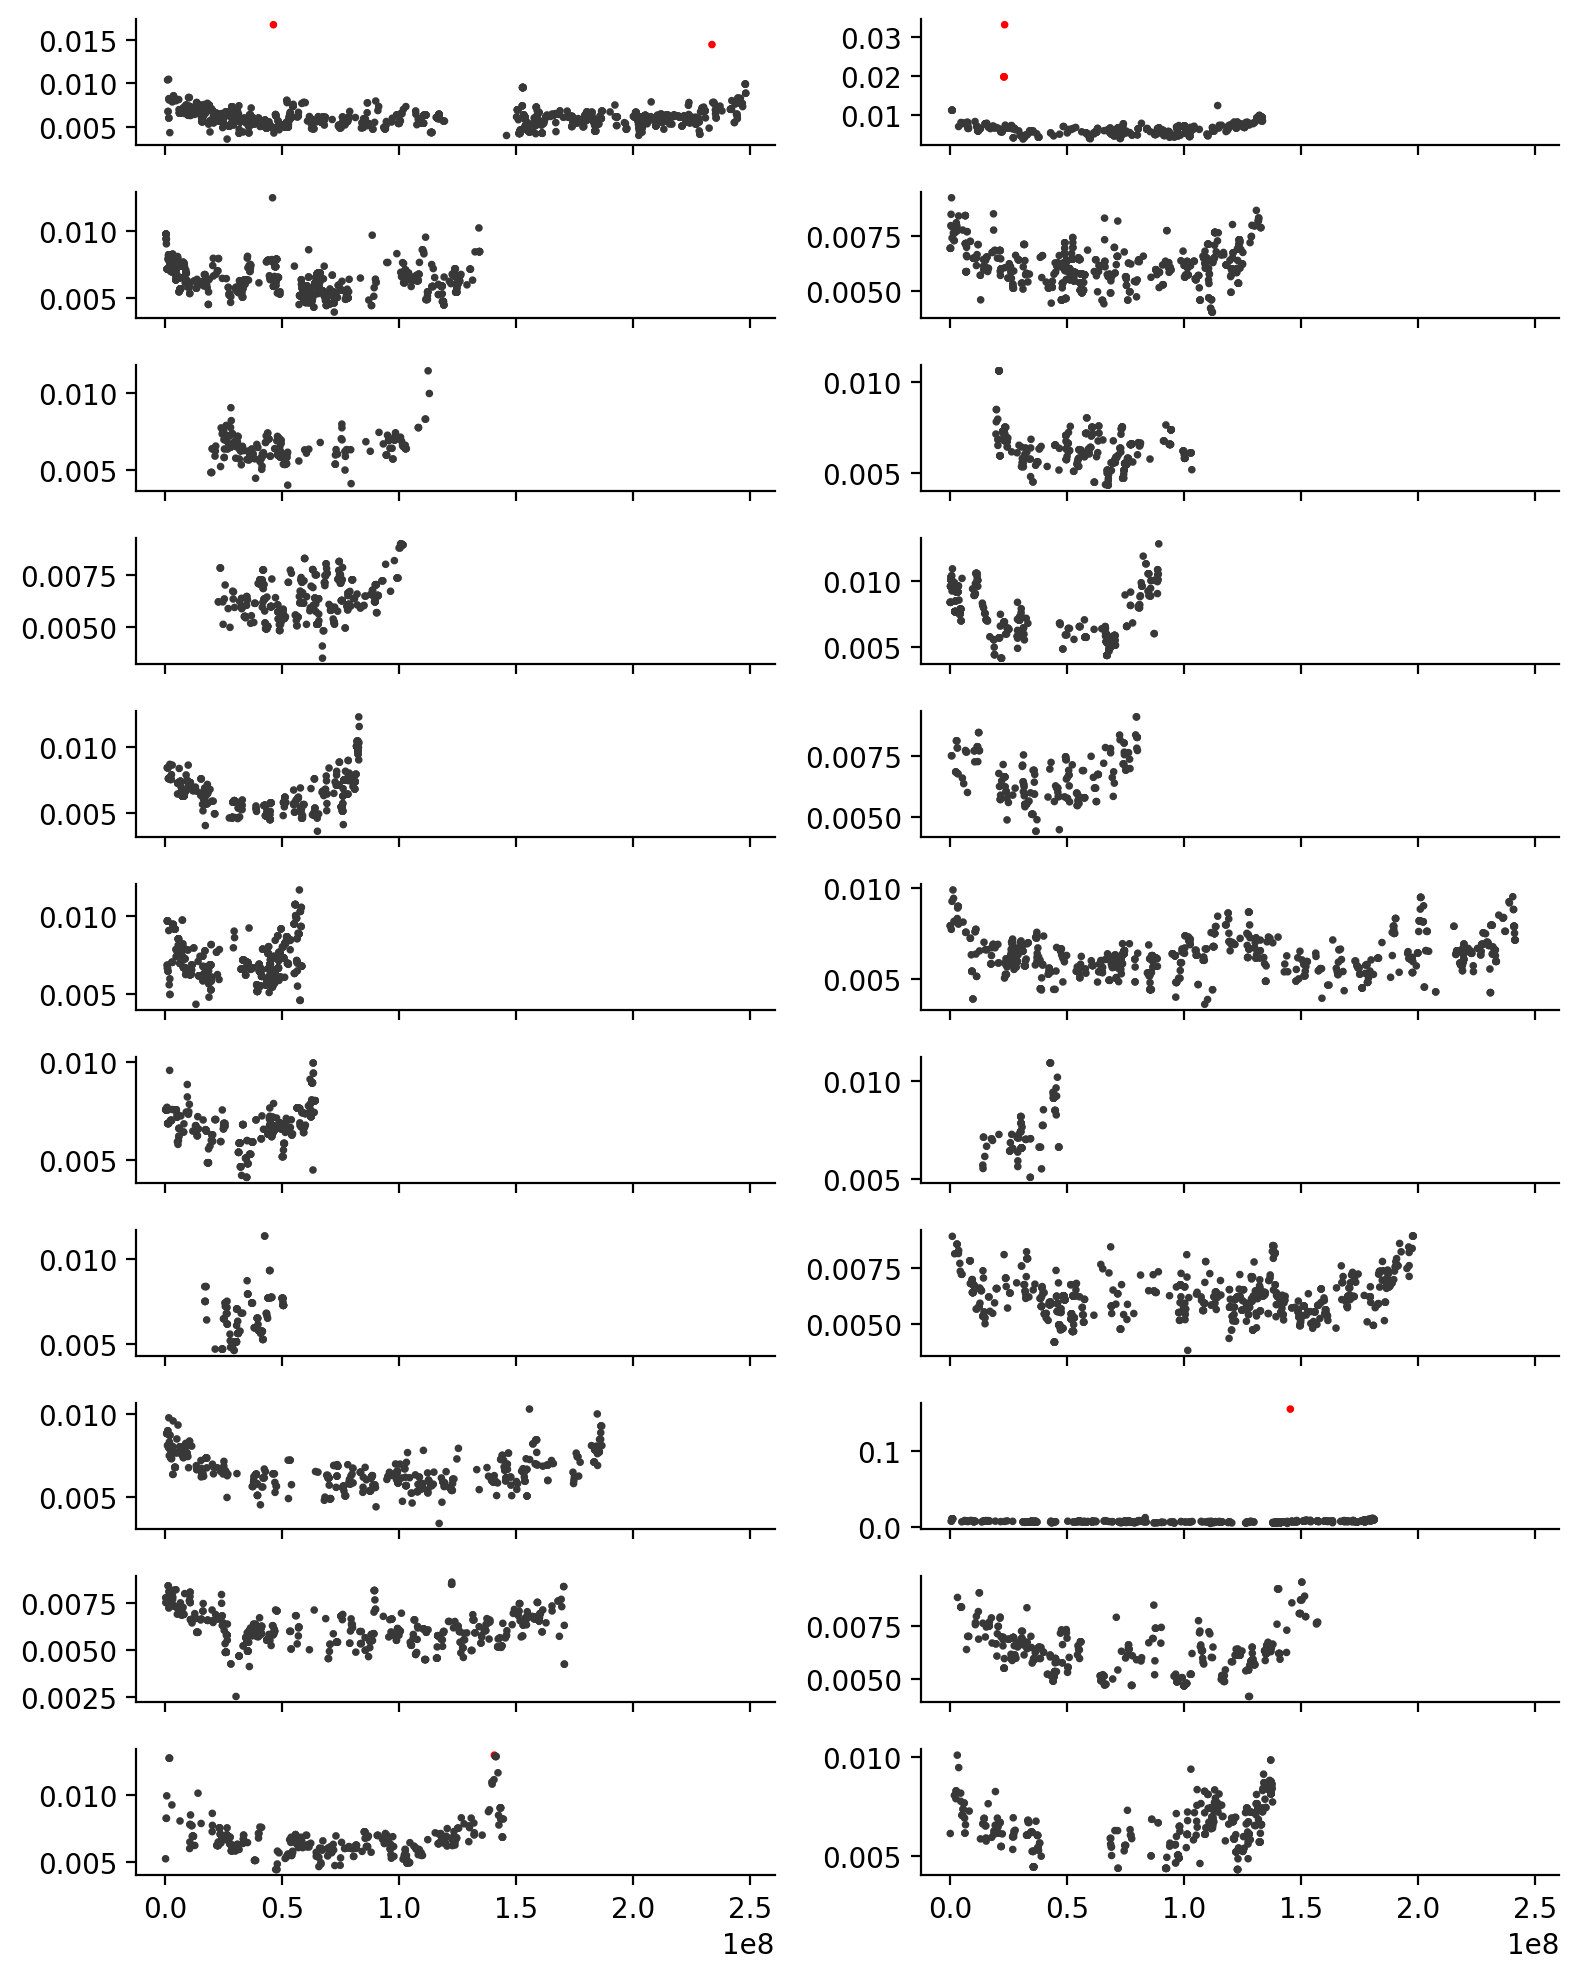

In [697]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [695]:
# remove outliers
do = d.loc[d['branch_length'] < thresh]

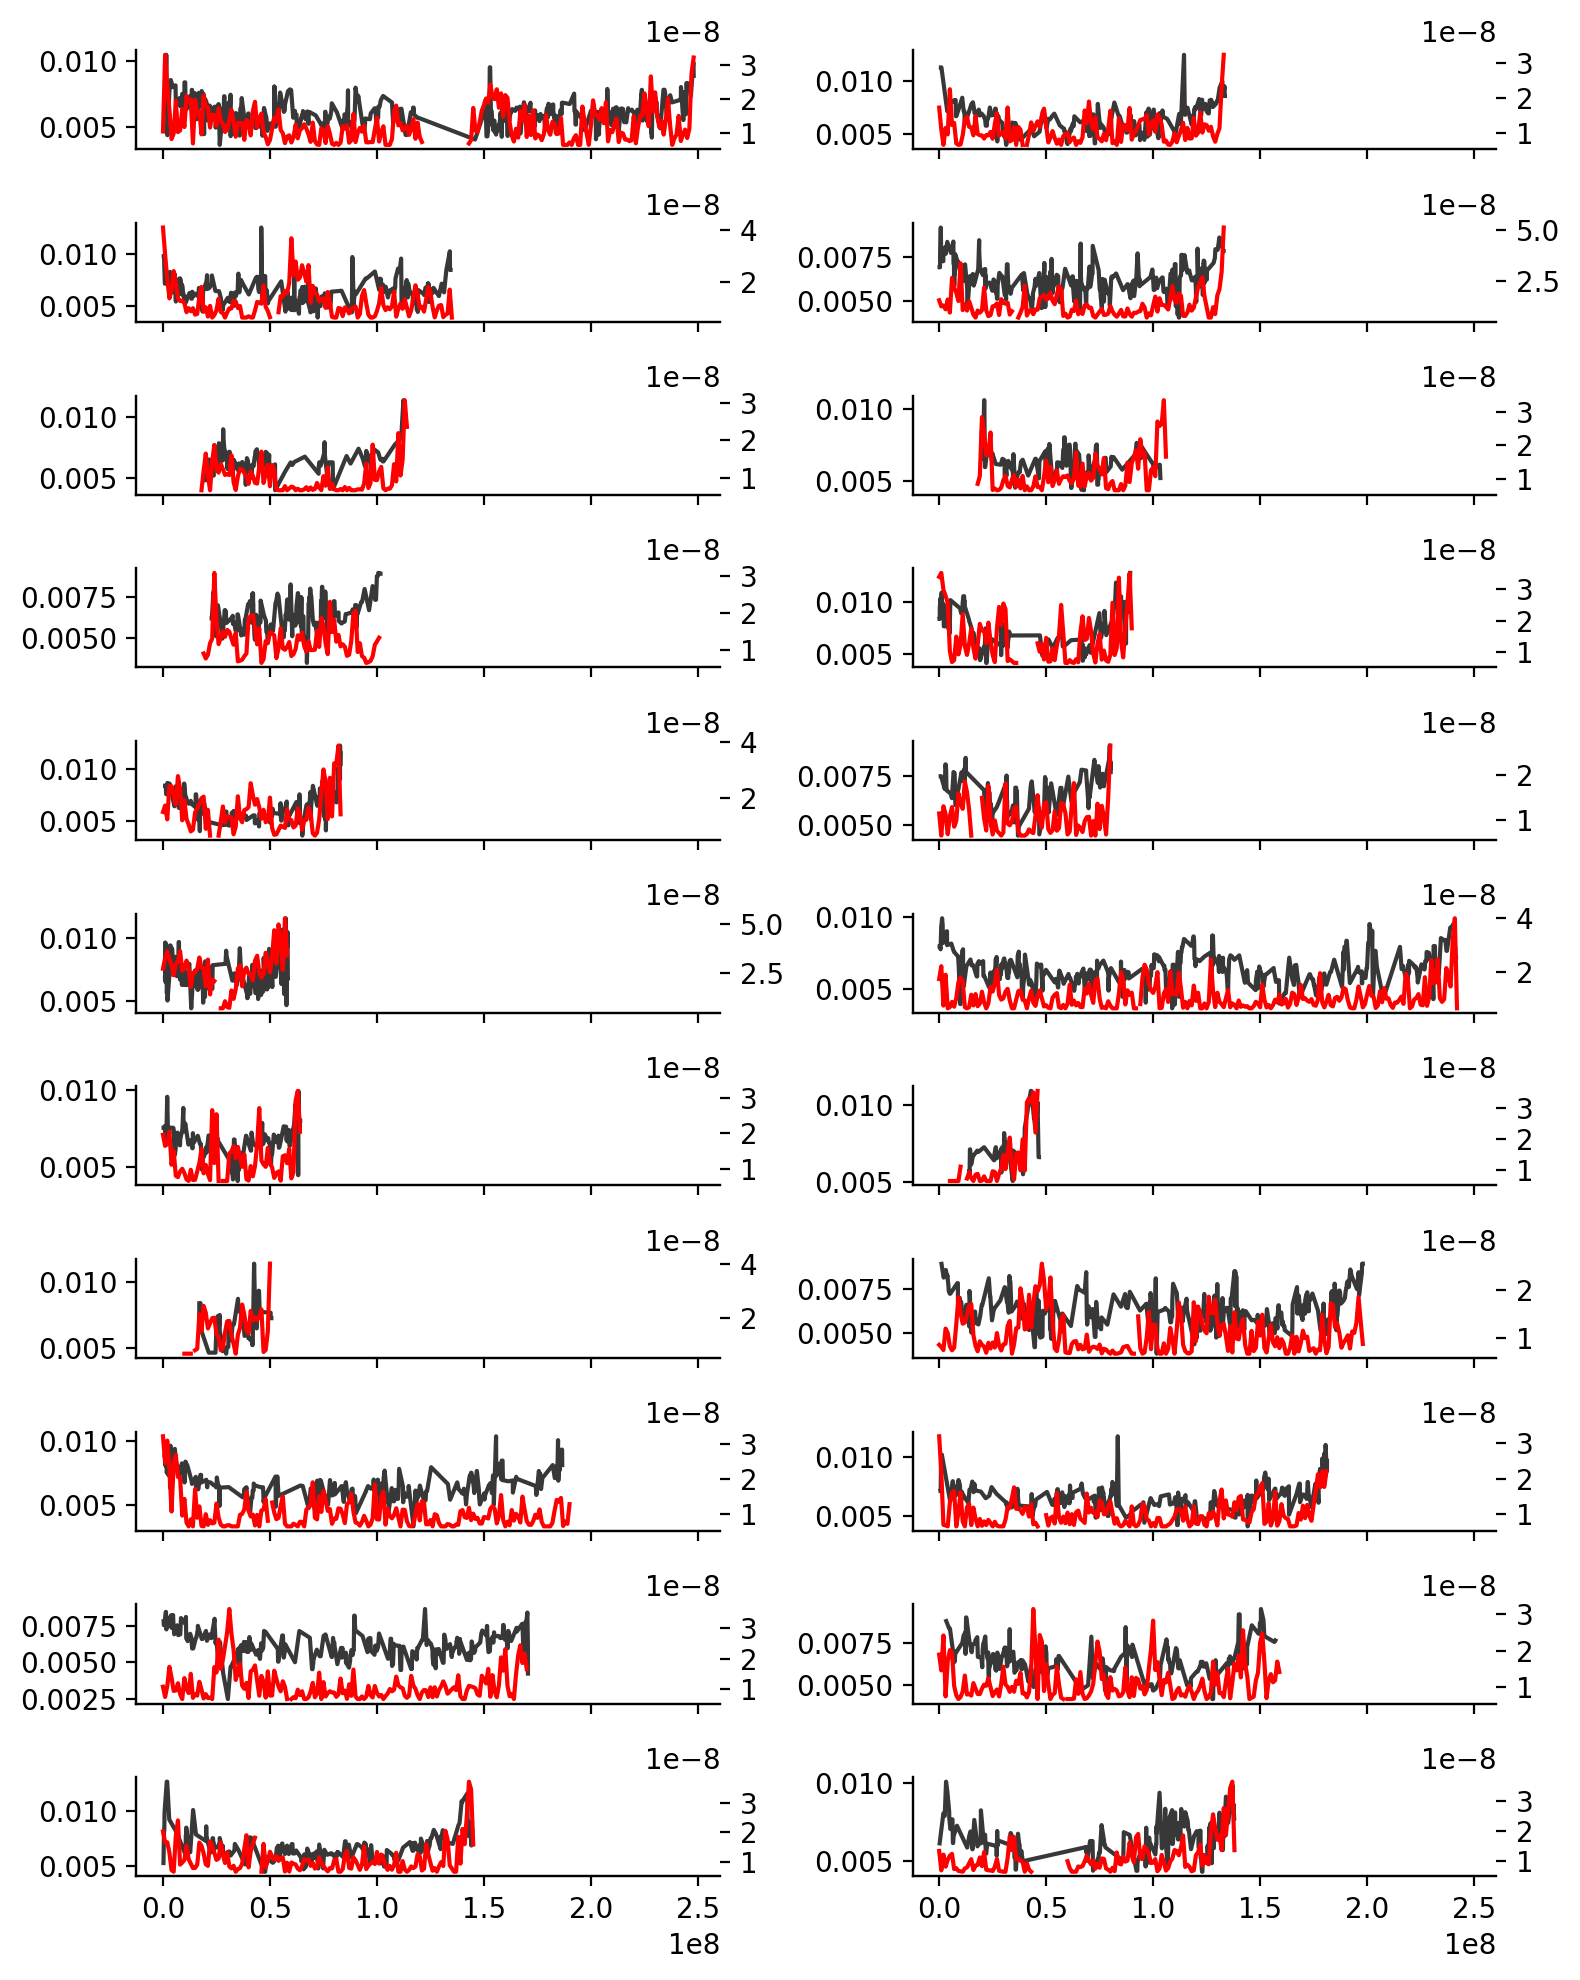

In [834]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(do['chrom'].unique()):
    dx = do.loc[do['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], dx['branch_length'], c='0.22')
    ax2 = fax.twinx()
    rx = r1Mb.loc[r1Mb['chrom'] == chrom]
    ax2.plot(rx['start'], rx['r'], c='r')
plt.tight_layout()

In [699]:
x, syn_prop, nonsyn_prop, branch_length = (do['r'].values, do['syn_prop'].values,
                                           do['nonsyn_prop'].values, do['branch_length'].values)

# nbins = 50
# dns = binned_summaries(x, nonsyn_prop, nbins)
# ds = binned_summaries(x, syn_prop, nbins)
# dbl = binned_summaries(x, branch_length, nbins)

In [773]:
import warnings
from sklearn.model_selection import KFold, LeaveOneOut
from collections import defaultdict

warnings.filterwarnings(action='once')


bin_range = (x.min(), 1.001*x.max())


kf = KFold(n_splits=100)
loo = LeaveOneOut()

mses = defaultdict(list)

cv_mses = []
nbs = []

def safe_mean(x):
    if not len(x) or np.all(~np.isfinite(x)):
        return np.nan
    return np.nanmean(x)

for nb in np.arange(5, 200, 2).astype(int):
    for train, test in kf.split(x):
        bins = cutbins(x[train], nb, xrange=bin_range)
        bin_means = binned_statistic(x[train], branch_length[train], statistic=safe_mean, bins=bins)
        bin_ns = binned_statistic(x[train], branch_length[train], statistic=lambda x: np.sum(np.isfinite(x)), bins=bins)
        idx = np.digitize(x[test], bins)
        se = (bin_means.statistic[idx-1] - branch_length[test])**2
        weights = bin_ns.statistic[idx-1]
        keep = np.isfinite(se)
        mse = np.average(se[keep], weights=weights[keep])
        mses[nb].append(mse)
        cv_mses.append(mse)
        nbs.append(nb)
        

Text(0.5, 0, 'number of bins')

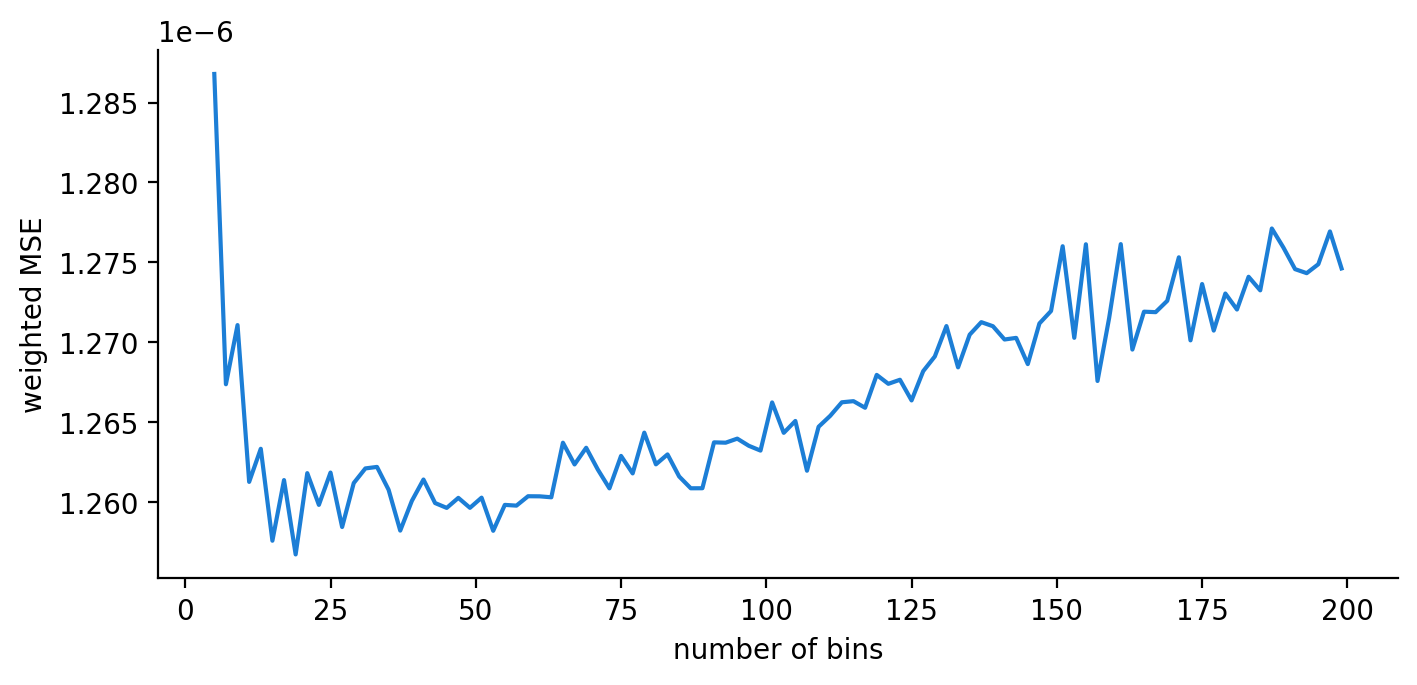

In [774]:
msedat = {nb: np.mean(v) for nb, v in mses.items()}

plt.plot(msedat.keys(), msedat.values())
plt.ylabel("weighted MSE")
plt.xlabel("number of bins")

In [775]:
best_nbin = list(msedat.keys())[np.argmin(list(msedat.values()))]
best_nbin

19

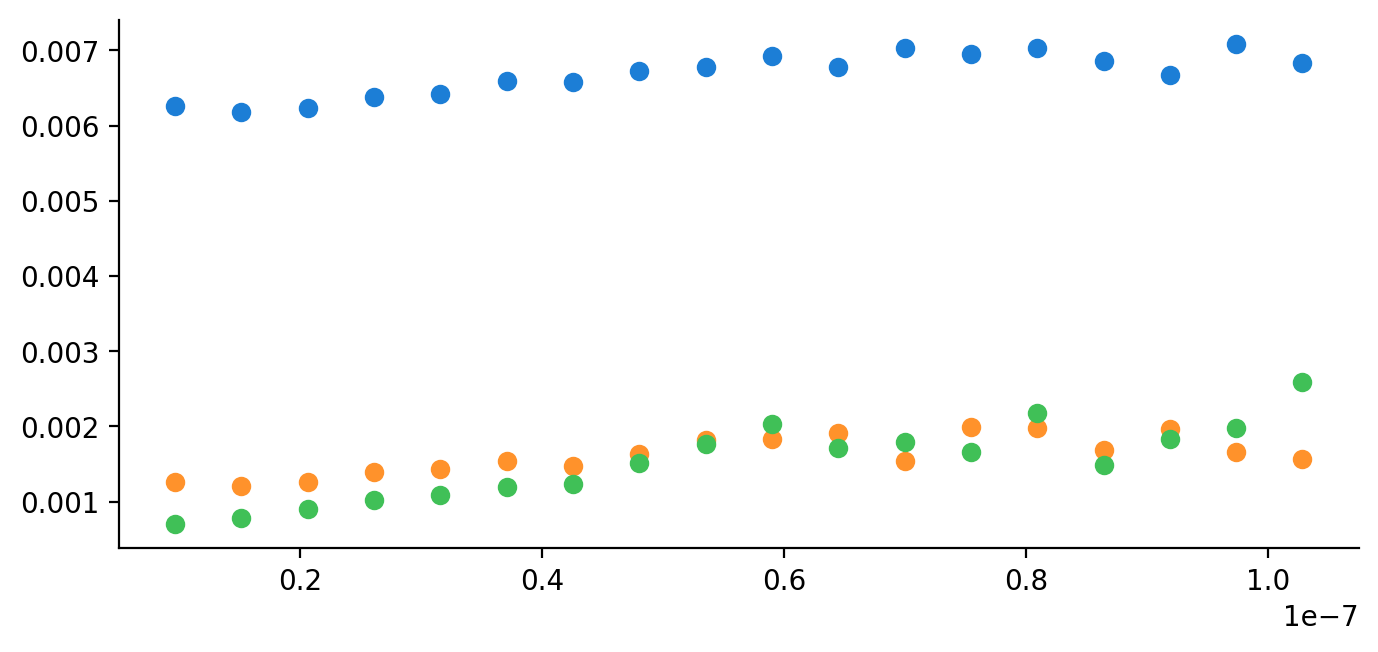

In [776]:
nbins = best_nbin
plt.scatter(*bin2pairs(binned_statistic(x, branch_length, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, nbins))))

In [777]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen']

rd = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t', names=cols)
                     
rd.groupby('feature')['r'].mean()

feature
cds          1.055389e-07
phastcons    6.620515e-09
utr          1.028444e-07
Name: r, dtype: float64

In [778]:
nbins = best_nbin

dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

In [793]:
min_n = 30
dnsx = dns.loc[dns['n'] > min_n]
dsx = ds.loc[ds['n'] > min_n]
dblx = dbl.loc[dbl['n'] > min_n]


Text(0, 0.5, 'proportion substitutions')

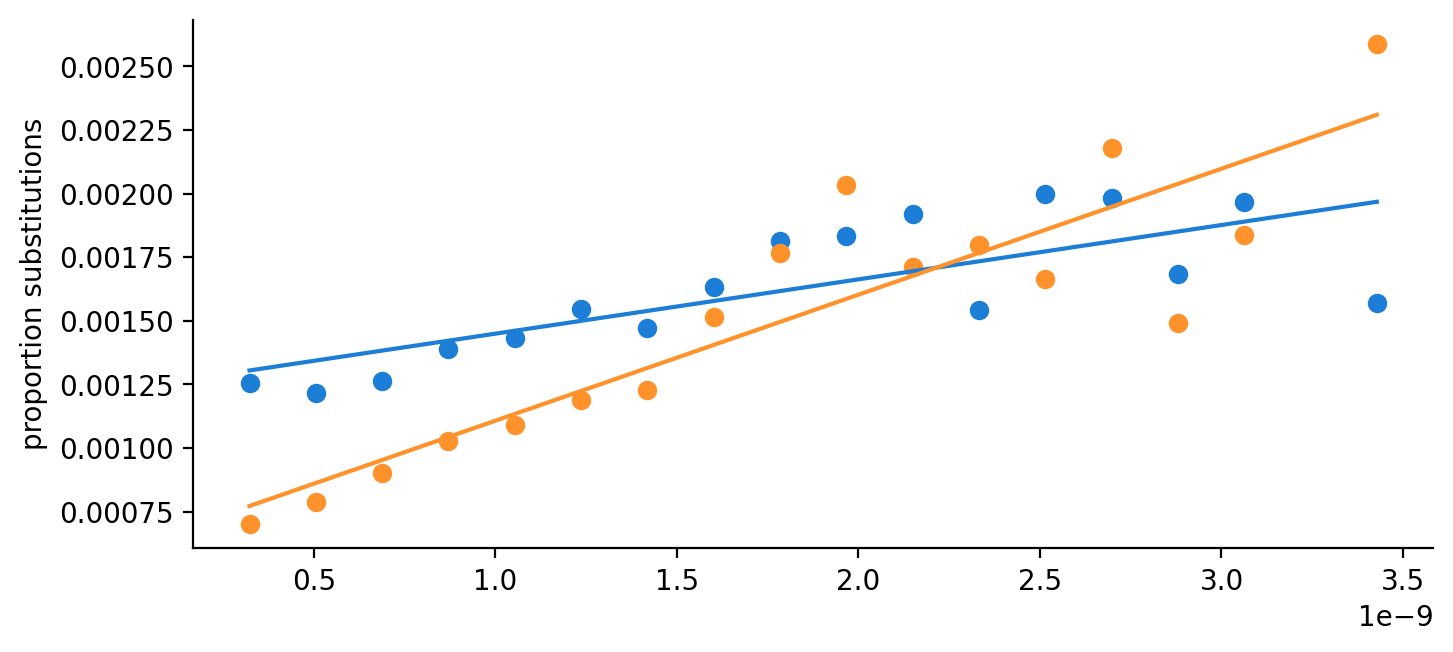

In [794]:
syn_lfit = stats.linregress(dsx['midpoint']/gen, dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint']/gen, dnsx['mean'])

fig, ax = plt.subplots()
ax.scatter(dsx['midpoint']/gen, dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)/gen
ax.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

ax.scatter(dnsx['midpoint']/gen, dnsx['mean'], label='non-syn')
ax.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)
ax.set_ylabel('proportion substitutions')

In [795]:
def JC69(dist):
    # distance
    return 0.75 - 0.75*np.exp(-4/3 * dist)

def sub_model(lambda_d, beta, T, a, use_JC69=False):
    dist = a*T + T*beta*lambda_d
    if use_JC69:
        return 0.75 - 0.75*np.exp(-4/3 * dist)
    return dist

In [796]:
binned_r, binned_bl = dblx['midpoint'].values, dblx['mean'].values
r, bl = d['r'].values, d['branch_length'].values

(array([9.894e+03, 1.669e+03, 5.630e+02, 1.680e+02, 9.100e+01, 7.200e+01,
        1.100e+01, 5.000e+00, 3.000e+00, 5.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

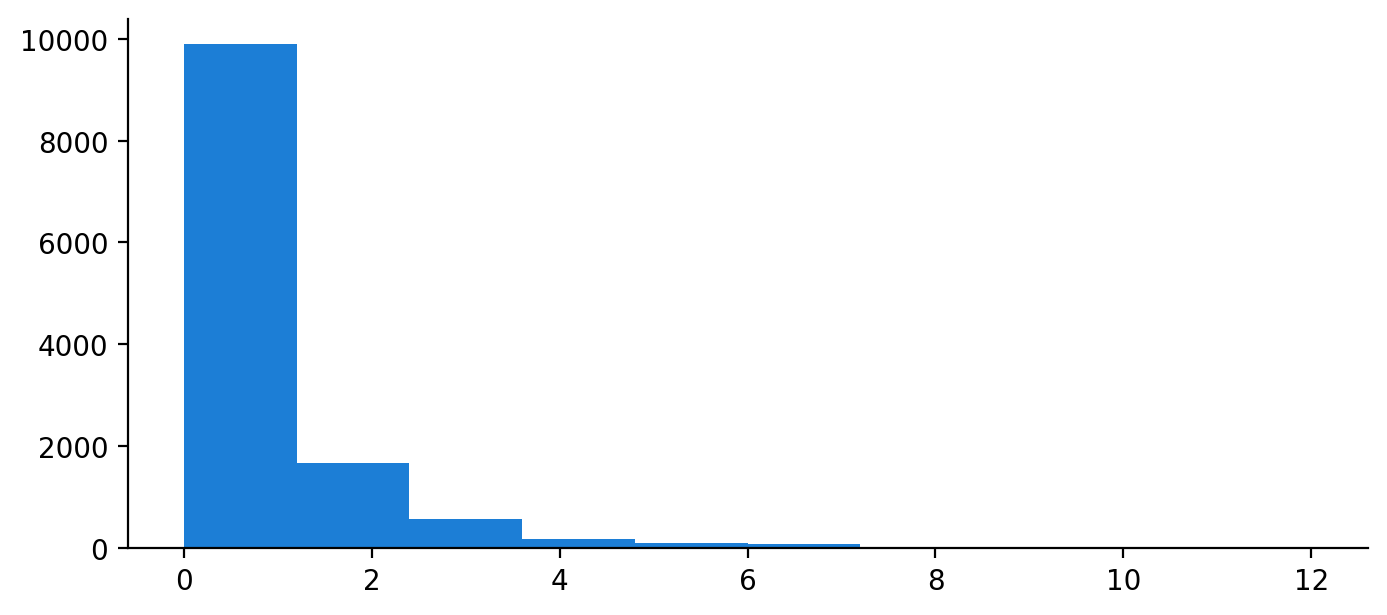

In [797]:
dnds = d['dnDs']
dnds = dnds[np.isfinite(dnds)]
plt.hist(dnds)

In [798]:
np.quantile(dnds, 0.99)

5.0

In [799]:
keep = (d['width'] > 10) & (d['dNdS'] < 5)
r, bl = r[keep], bl[keep]

In [800]:
def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

bin_xx, bin_yy, bin_fit = fit_JC69(binned_r, binned_bl)
xx, yy, fit = fit_JC69(r, bl)

In [801]:
bin_fit

(array([1.26704436e-02, 1.95363883e+07, 3.18285601e-10]),
 array([[ 5.02087296e+07, -7.74468217e+16,  1.26125940e+00],
        [-7.74468217e+16,  1.19461501e+26, -1.94548902e+09],
        [ 1.26125940e+00, -1.94548902e+09,  3.16832410e-08]]))

In [802]:
fit

(array([1.56750862e-02, 1.92398732e+07, 3.21718879e-10]),
 array([[ 2.38865567e+07, -2.93187749e+16,  4.90252887e-01],
        [-2.93187749e+16,  3.59863739e+25, -6.01744915e+08],
        [ 4.90252887e-01, -6.01744915e+08,  1.00620569e-08]]))

In [803]:
dblx.sort_values('midpoint').tail()

,start,end,midpoint,mean,sd,n
12,7.817830e-08,7.269783e-08,7.543806e-08,0.006950,0.001496,104.0
13,8.365877e-08,7.817830e-08,8.091853e-08,0.007031,0.001306,119.0
14,8.913924e-08,8.365877e-08,8.639900e-08,0.006857,0.001302,87.0
15,9.461971e-08,8.913924e-08,9.187947e-08,0.006678,0.001506,76.0
17,1.055806e-07,1.001002e-07,1.028404e-07,0.006834,0.001200,183.0


Text(0.5, 0, 'predicted substitution rate')

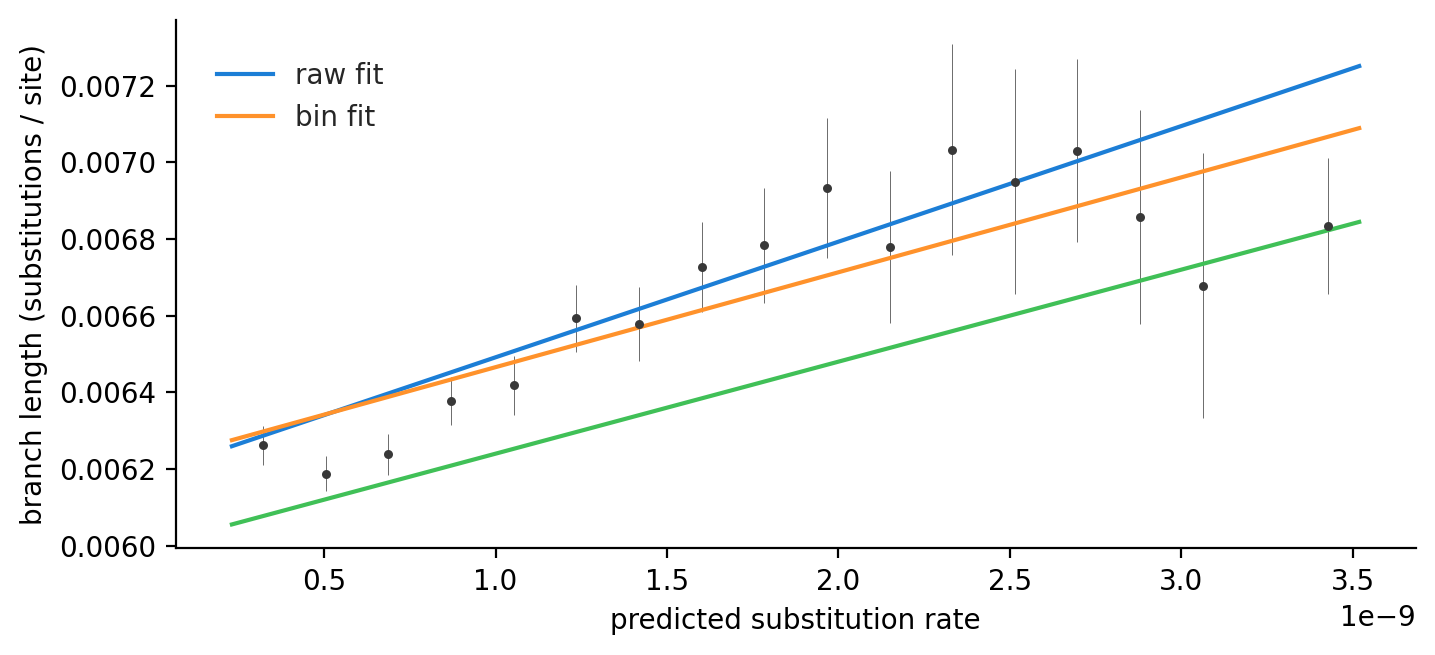

In [804]:
fig, ax = plt.subplots()
ax.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='raw fit')
ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.02
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid)
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [791]:
def print_subfit(fit, gen_time=30):
    beta, T, a = fit[0]
    info = (f"intercept (λ_B T), a = {a:.3g}\n"
            f"  λ_B = {a / T:.3g} \n"
            f"T = {T/1e6:.4g} (Mya)\n"
            f"β = {beta:.3g}\n"
            f"{(a / T) / (a + T*beta*1e-9)}")
    print(info)
    
print_subfit(fit)

intercept (λ_B T), a = 3.22e-10
  λ_B = 1.67e-17 
T = 19.24 (Mya)
β = 0.0157
5.544491672682292e-14


In [792]:
print_subfit(bin_fit)

intercept (λ_B T), a = 3.18e-10
  λ_B = 1.63e-17 
T = 19.54 (Mya)
β = 0.0127
6.581669282481193e-14
